In [1]:
%matplotlib notebook 

import matplotlib.pyplot as plt
import numpy as np

#import h5py
#from unwrap import unwrap

from scipy.constants import e, m_e, c, pi, epsilon_0, mu_0
from tqdm.auto import tqdm

#from axiprop.lib import PropagatorResampling
from axiprop.lib import PropagatorResamplingFresnel
from axiprop.lib import PropagatorResamplingPlasma
from axiprop.common import ScalarField
from axiprop.utils import mirror_parabolic

from axiprop.plasma import make_ADK
from axiprop.plasma import get_plasma_ionized
from axiprop.plasma import get_plasma_OFI

from LPICS.ics import CheatSheet

r_e = e**2 / (4 * np.pi * epsilon_0 * m_e * c**2)

In [2]:
from copy import deepcopy

mycmap = deepcopy(plt.cm.Greys)
mycmap._init()
filt = np.r_[0:1:32j]
mycmap._lut[-filt.size:, 0] += filt

myReds = deepcopy(plt.cm.Reds)
myReds._init()
myReds._lut[:, -1] = np.sin(np.r_[0:np.pi/2:259j])**4

def plot_colored(x, y, z, cmap=plt.cm.jet, steps=10, **kw_args):
    z = np.asarray(z)
    z -= z.min()
    z /= z.max()
    it=0
    while it<z.size-steps:
        x_segm = x[it:it+steps+1]
        y_segm = y[it:it+steps+1]
        c_segm = cmap( z[it+steps//2] )
        plt.plot(x_segm, y_segm, c=c_segm, **kw_args)
        it += steps

In [3]:
# Laser init
lambda0 = 0.8e-6
tau_fwhm = 28e-15
R_las = 38.1e-3
check_laser = True
Intensity = 5e16
a0 = 0.02

# Mirror
R_mirr = R_las
f_N = 40                 # f-number f/40 
f0 = 2 * R_mirr * f_N    # focal length
w0 = 2 / np.pi * lambda0 * f_N

L_R = np.pi * w0**2 / lambda0

# Plasma
n_gas = 8e17 * 1e6
my_element = 'H'

channel_coef = 1./( np.pi * r_e * w0**2 * n_gas )
channel_pow = 2

k_p = (e**2 * n_gas / m_e / epsilon_0)**0.5 / c
kp2 = k_p**2

pack_ADK, Uion = make_ADK(my_element)

def dens_func(z, r):
    r_profile = 1. + channel_coef * np.abs(r / w0)**channel_pow
    r_profile *= np.exp( -( r / (2.5 * w0) )**6 )
    r_profile += 1 - np.exp(- ( r / (2.5 * w0) )**6 )
    #r_profile = np.ones_like(r)
    z_profile = (z>=f0) + np.exp( -(z - f0)**4 / L_R**4 ) * (z<f0)
    
    return r_profile * z_profile

# Numeric parameters
tau = tau_fwhm / (2*np.log(2))**0.5
k0 = 2 * np.pi / lambda0

L_kz = 16 / (c*tau)

Rmax = 3.5 * R_las
Nr = 512

Rmax_new = 150e-6
Nr_new = 256
Nkr_new = 512

laser_cs = CheatSheet(a0=a0, w0=w0*1e6,
                      tau_fwhm=tau_fwhm * 1e15,
                      )

EnergyLaser = laser_cs.prm['Energy']
a0 = laser_cs.prm['a0']
a0_far = a0 / (1 + (f0/L_R)**2)**0.5
n_c = 1e6 * laser_cs.prm['n_c']

In [4]:
dt = lambda0 / c / 32

Fields = {}
field_names = ['E_init', 'E_foc', 'A_foc', 'J_plasma']

for field in field_names:
    Fields[field] = ScalarField(k0, L_kz, (-6*tau, 6*tau), dt, n_dump=32)

k_freq = Fields['E_init'].k_freq

prop_far = PropagatorResamplingFresnel(
    r_axis=(Rmax, Nr),
    kz_axis=k_freq,
    r_axis_new=(Rmax_new, Nr_new),
    Nkr_new=Nkr_new,
    N_pad=8,
    backend='NP',
)

prop_plasma = PropagatorResamplingPlasma(
       r_axis=prop_far.r_new,
       kz_axis=k_freq,
       backend='NP',
)

Available backends are: NP, CL, CU, NP_FFTW
NP is chosen
Available backends are: NP, CL, CU, NP_FFTW
NP is chosen


<IPython.core.display.Javascript object>


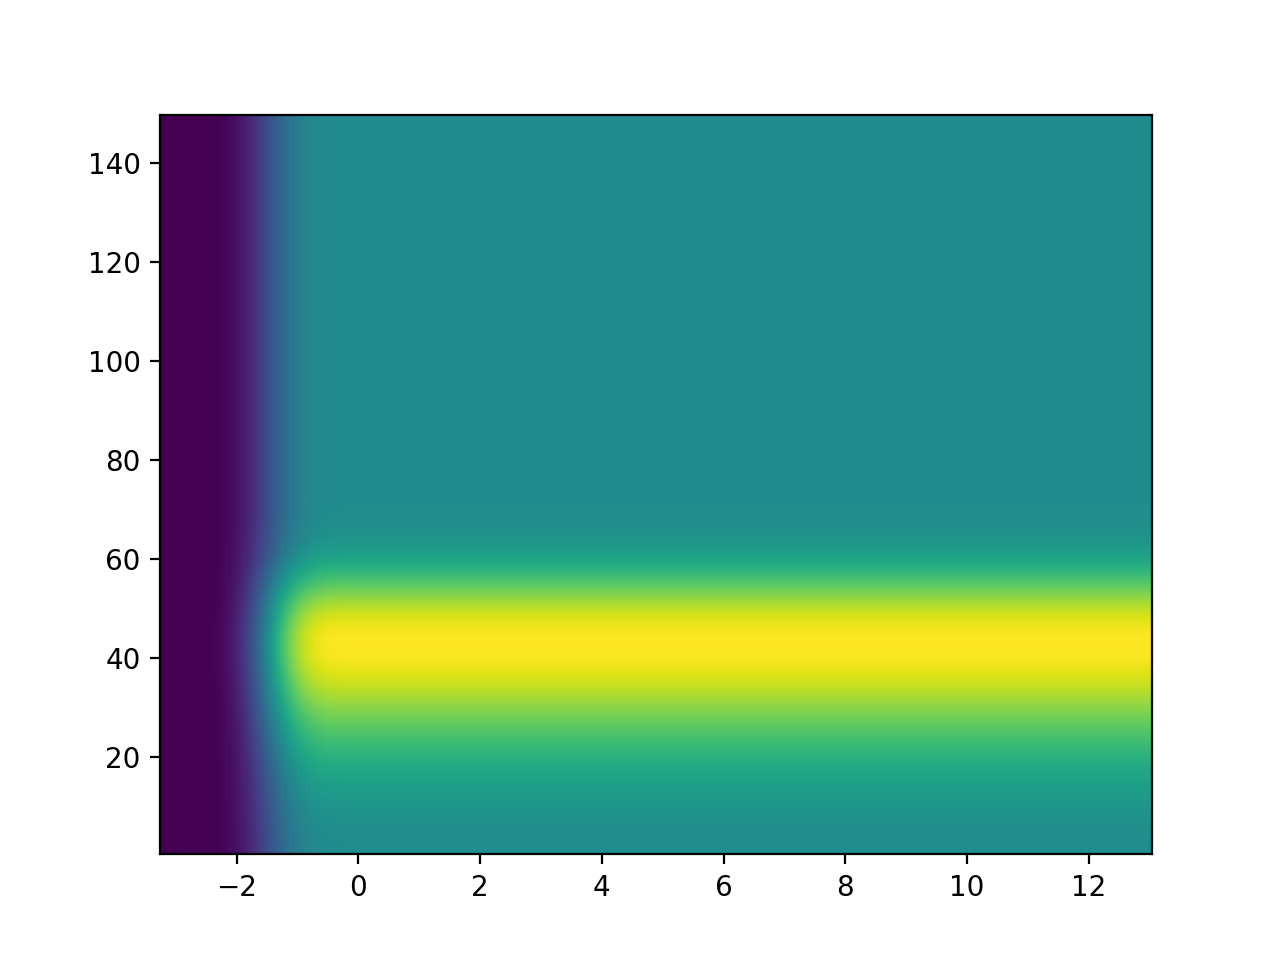

In [5]:
# distance from mirror to plasma
z_0 = f0 - 2 * L_R

# Propagation axis in plasma
z_axis = z_0 + np.r_[0 : 10 * L_R : 600j]
dz_step = np.gradient(z_axis)

plt.figure()
ext = np.array([(z_axis-f0).min(), (z_axis-f0).max(),
                prop_plasma.r_new.min(), prop_plasma.r_new.max(),
               ])

ext[:2] *= 1e3
ext[2:] *= 1e6

plt.imshow(dens_func(z_axis[:, None], prop_plasma.r_new[None,:]).T,
           aspect='auto', origin='lower',
           extent=ext,
          )

In [6]:
# distance from mirror to plasma
z_0 = f0 - 2 * L_R

# Propagation axis in plasma
z_axis = z_0 + np.r_[0 : 10 * L_R : 600j]
dz_step = np.gradient(z_axis)

# Making the laser
Fields['E_init'].make_gaussian_pulse(a0_far, tau, prop_far.r, R_las, n_ord=2 )
E_far = Fields['E_init'].Field_ft.copy()

# Adding the mirror
E_far *= mirror_parabolic( f0, prop_far.kz, prop_far.r )

# Propagate field to the plasma
E_near = prop_far.step(E_far, z_0)

# Initiate plasma propagator
prop_plasma.initiate_stepping(E_near)
fields_sync = True

# Initiate diagnostics
dn_diags = 6
E_onax = []
I_on_r = []
W_laser = []

CurrentField = 'Motion'

# Main loop
for iz in tqdm(range(z_axis.size)):
    t_loc = (z_0 + prop_plasma.z_propagation) / c
    n_pe0 = n_gas * dens_func( z_axis[iz], prop_plasma.r_new )
    
    fields_sync = False
    
    if np.mod(iz, dn_diags)==0:
        Fields['E_foc'].import_field_ft(
            E_near, t_loc, r=prop_plasma.r_new)

        E_onax.append( Fields['E_foc'].Field[:,0] )
        I_on_r.append( (Fields['E_foc'].Field**2).sum(0)*dt )
        W_laser.append( Fields['E_foc'].Energy )
        fields_sync = True
        
    if CurrentField=='Simple':
        kp2_ax = (e**2 * n_pe0 / m_e / epsilon_0) / c**2
        kp2 = kp2_ax[0]

        Fields['J_plasma'].import_field_ft(
            1j * kp2_ax[None,:] * E_near / (Fields['E_foc'].omega[:,None] * mu_0),
            t_loc, r=prop_plasma.r_new, transform=False)

    if CurrentField=='Motion':
        A_near = 1j *  E_near / Fields['E_foc'].omega[:,None]

        Fields['A_foc'].import_field_ft(
            A_near, t_loc, r=prop_plasma.r_new
        )
        
        if not fields_sync:
            Fields['E_foc'].import_field_ft(
                E_near, t_loc, r=prop_plasma.r_new)

        J_plasma, n_e, T_e = get_plasma_ionized(
            Fields['E_foc'].Field, Fields['A_foc'].Field, 
            dt, n_pe0
        )

        Fields['J_plasma'].import_field(
            J_plasma, t_loc, r=prop_plasma.r_new,
        )
        
        kp2 = (e**2 * n_e[0] / m_e / epsilon_0) / c**2
        
    if CurrentField=='Ionization':
        A_near = 1j *  E_near / Fields['E_foc'].omega[:,None]

        Fields['A_foc'].import_field_ft(
            A_near, t_loc, r=prop_plasma.r_new
        )
        
        if not fields_sync:
            Fields['E_foc'].import_field_ft(
                E_near, t_loc, r=prop_plasma.r_new)

        J_plasma, n_e, T_e = get_plasma_OFI(
            Fields['E_foc'].Field, Fields['A_foc'].Field, 
            dt, n_pe0, pack_ADK, Uion
        )

        Fields['J_plasma'].import_field(
            J_plasma, t_loc, r=prop_plasma.r_new,
        )

        kp2 = (e**2 * n_e[0] / m_e / epsilon_0) / c**2  

    E_near = prop_plasma.stepping_step(
        kp2, Fields['J_plasma'].Field_ft,
        dz_step[iz], u_out=E_near
    )  
    
    E_near[:,-Fields['E_foc'].n_dump:] *= Fields['E_foc'].dump_mask[None,:]
    
t_loc = (z_0 + prop_plasma.z_propagation) / c
Fields['E_foc'].import_field_ft(E_near, t_loc, 
                                r=prop_plasma.r_new)

E_onax.append(Fields['E_foc'].Field[:,0])
I_on_r.append((Fields['E_foc'].Field**2).sum(0)*dt)
W_laser.append(Fields['E_foc'].Energy)
    
E_onax = np.array(E_onax)
I_on_r = np.array(I_on_r)
W_laser = np.array(W_laser)

  0%|          | 0/600 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


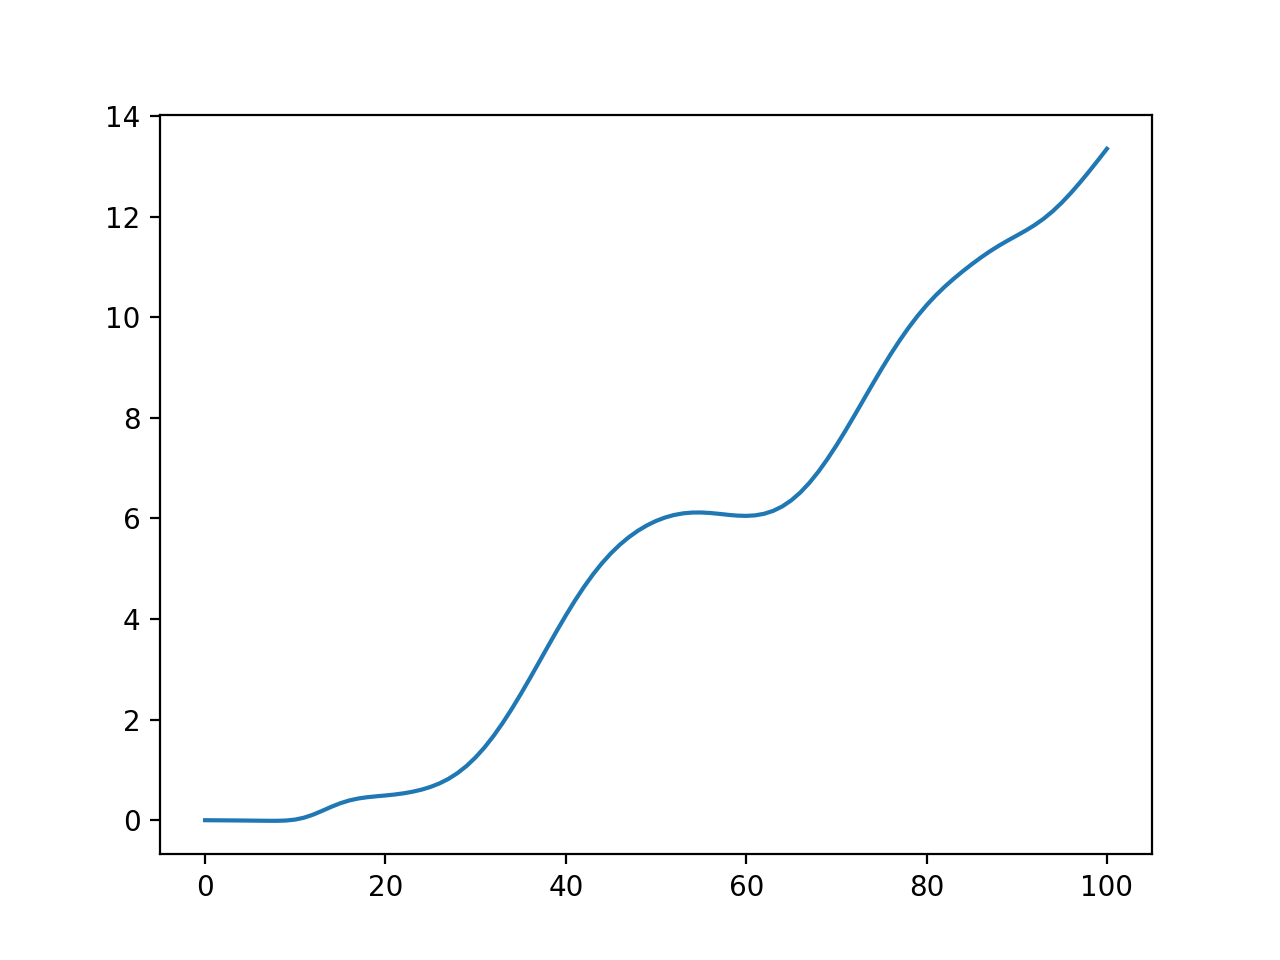

<IPython.core.display.Javascript object>


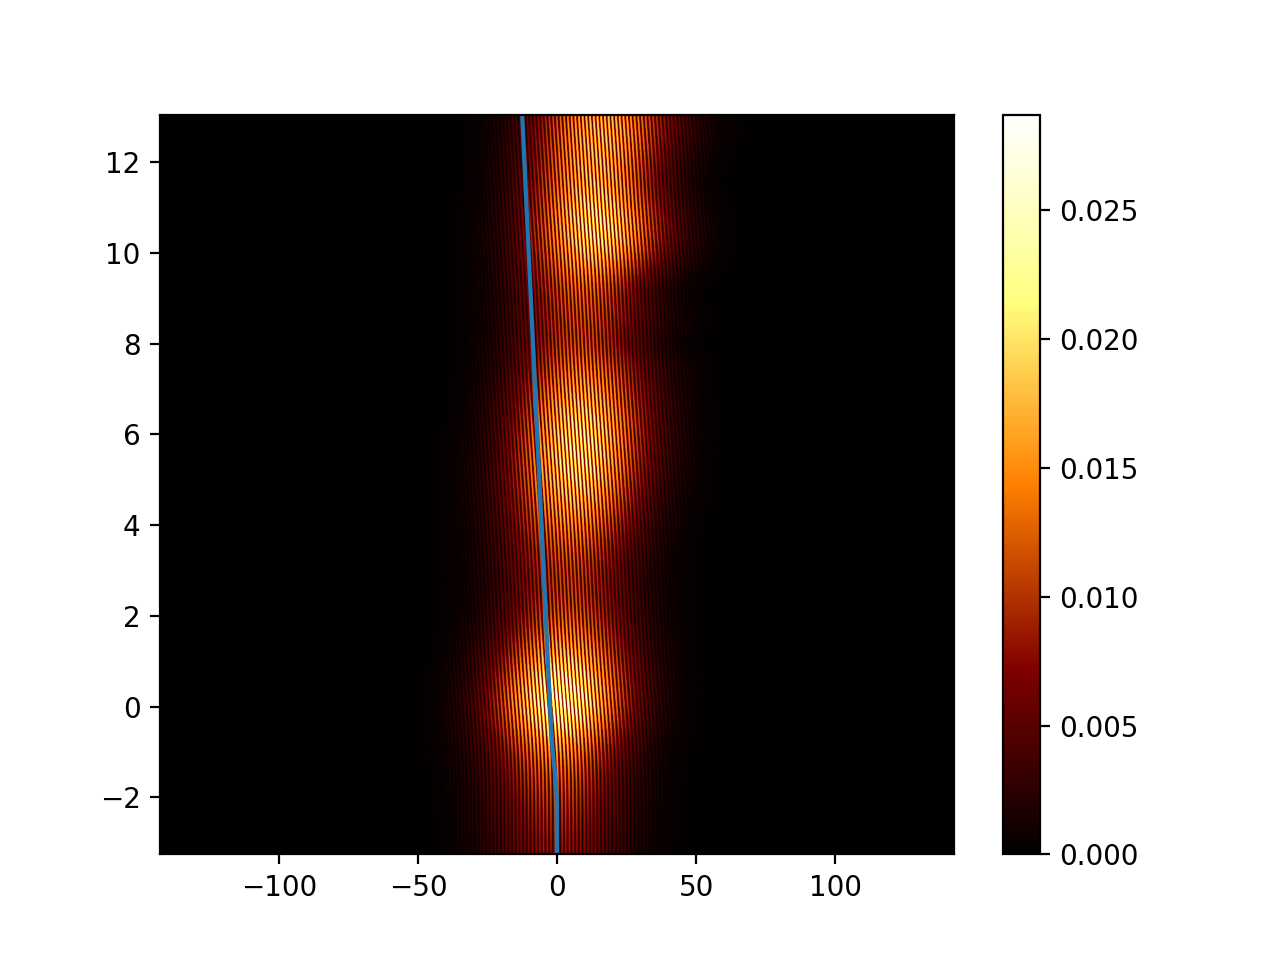

<IPython.core.display.Javascript object>


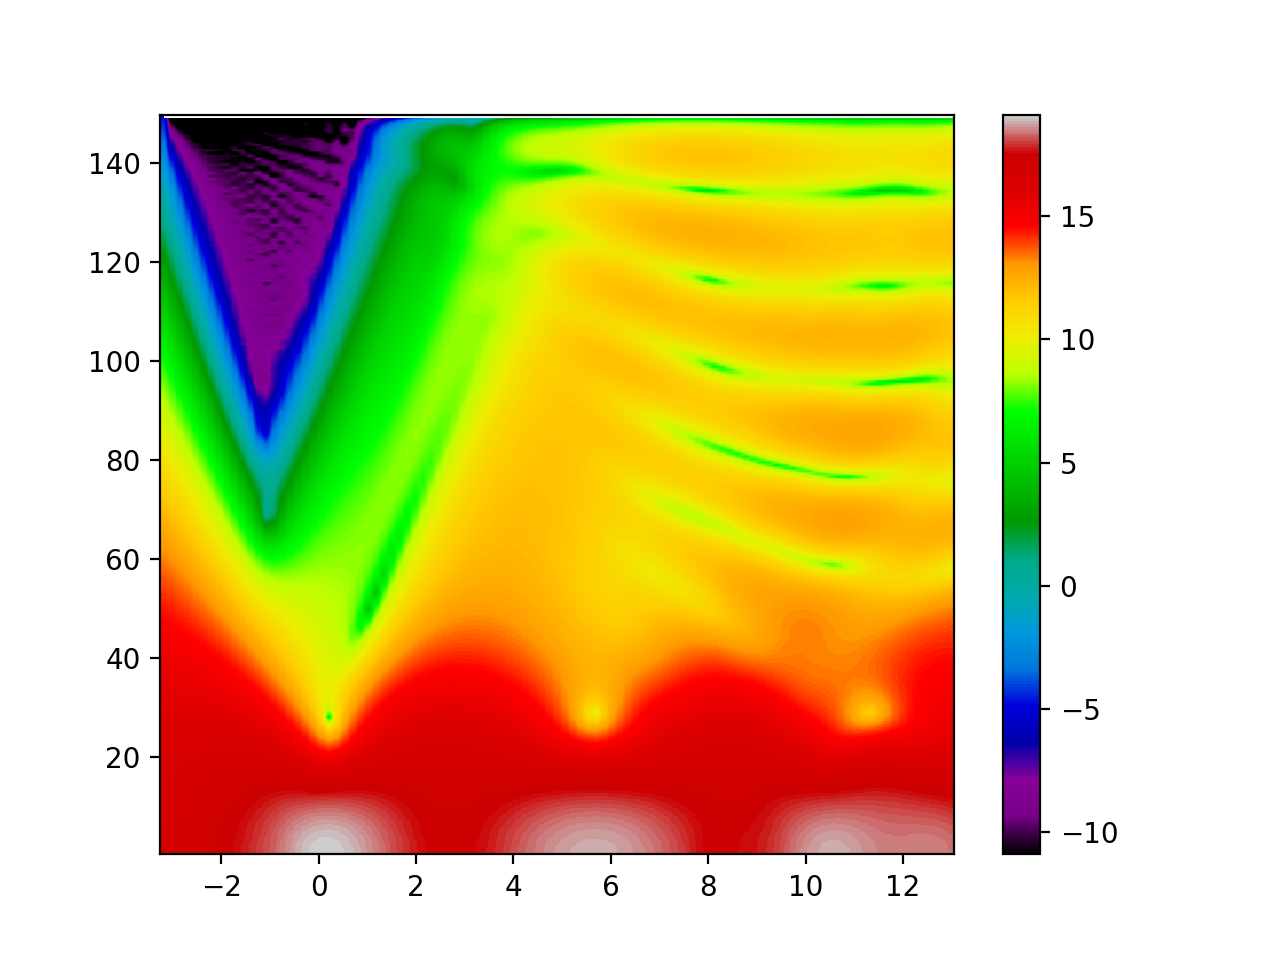

/tmp/ipykernel_31368/3647489880.py:29: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(I_on_r)).T,
/tmp/ipykernel_31368/3647489880.py:33: RuntimeWarning: divide by zero encountered in log
  vmin=np.log(np.abs(I_on_r)).max()-30,


In [7]:
plt.figure()
plt.plot( (W_laser-W_laser[0])/W_laser[0] * 100 )

plt.figure()
ext = np.array([Fields['E_foc'].t.min(), Fields['E_foc'].t.max(), 
                (z_axis-f0).min(), (z_axis-f0).max() ])

ext[:2] *= 1e15
ext[2:] *= 1e3

plt.imshow(e*np.abs(E_onax) / (m_e*c**2*k0), 
           origin='lower', aspect='auto', 
           extent=ext, 
           cmap=plt.cm.afmhot,
          )

v_g = 1.0 - np.sqrt( 1.0 + n_gas * dens_func(z_axis, 0) / n_c )
plt.plot( v_g * (z_axis-z_axis[0])/c * 1e15 , (z_axis-f0)*1e3 )

plt.colorbar()

plt.figure()
ext = np.array([(z_axis-f0).min(), (z_axis-f0).max(),
                Fields['E_foc'].r.min(), Fields['E_foc'].r.max(),
               ])
ext[:2] *= 1e3
ext[2:] *= 1e6

plt.imshow(np.log(np.abs(I_on_r)).T, 
           origin='lower', aspect='auto', 
           extent=ext, 
           cmap=plt.cm.nipy_spectral,
           vmin=np.log(np.abs(I_on_r)).max()-30,
          )

plt.colorbar()

<IPython.core.display.Javascript object>


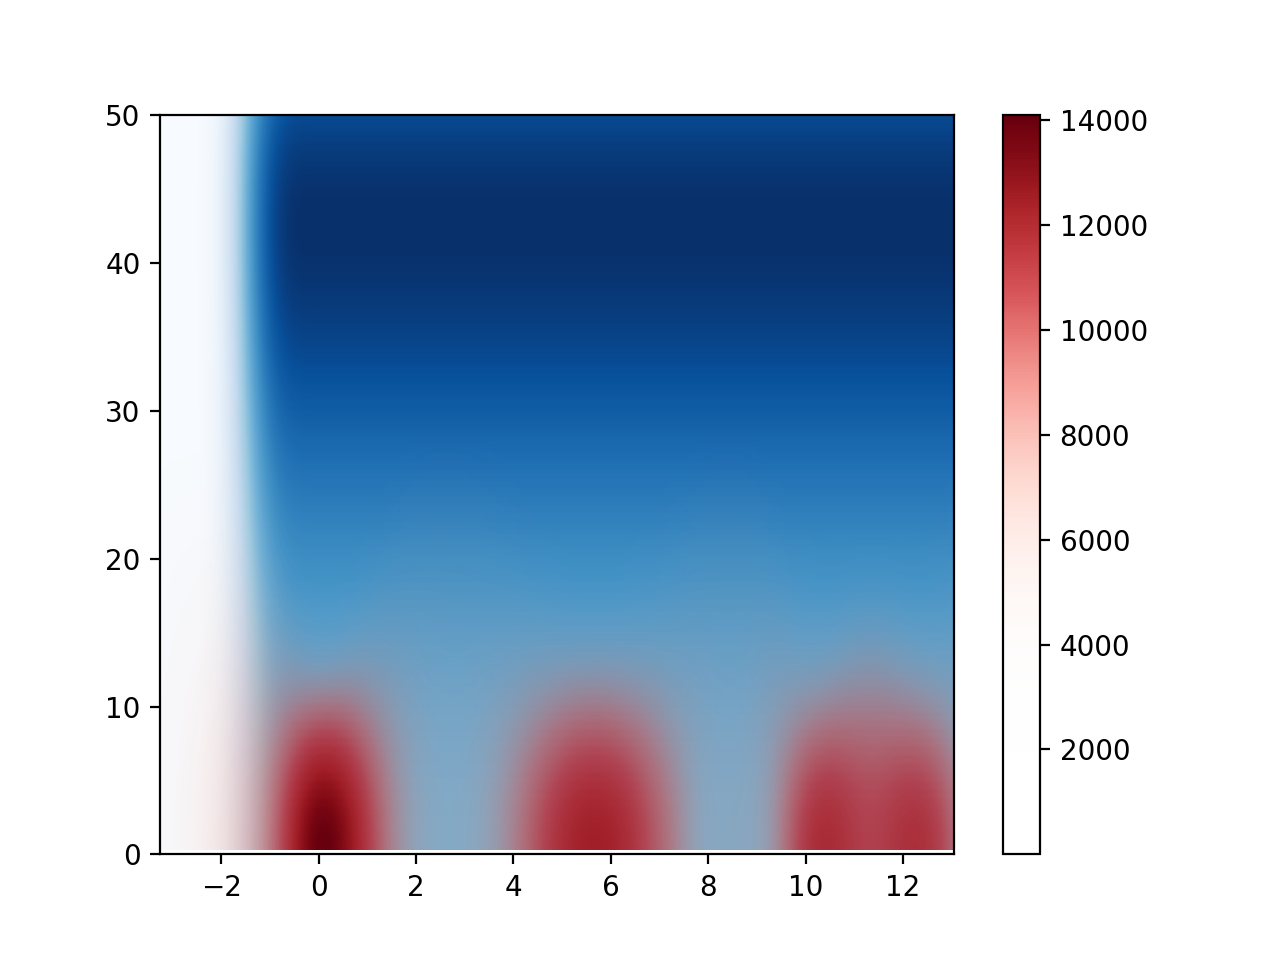

(0.0, 50.0)

In [14]:

plt.figure()
ext = np.array([(z_axis-f0).min(), (z_axis-f0).max(),
                Fields['E_foc'].r.min(), Fields['E_foc'].r.max(),
               ])

ext[:2] *= 1e3
ext[2:] *= 1e6

plt.imshow(dens_func(z_axis[:, None], prop_plasma.r_new[None,:]).T,
           aspect='auto', origin='lower',
           extent=ext,
           cmap=plt.cm.Blues
          )

val = (np.abs(I_on_r))**.5

plt.imshow(val.T, 
           origin='lower', aspect='auto', 
           extent=ext, 
           cmap=myReds, 
          )

plt.colorbar()

plt.ylim(0,50)

<IPython.core.display.Javascript object>


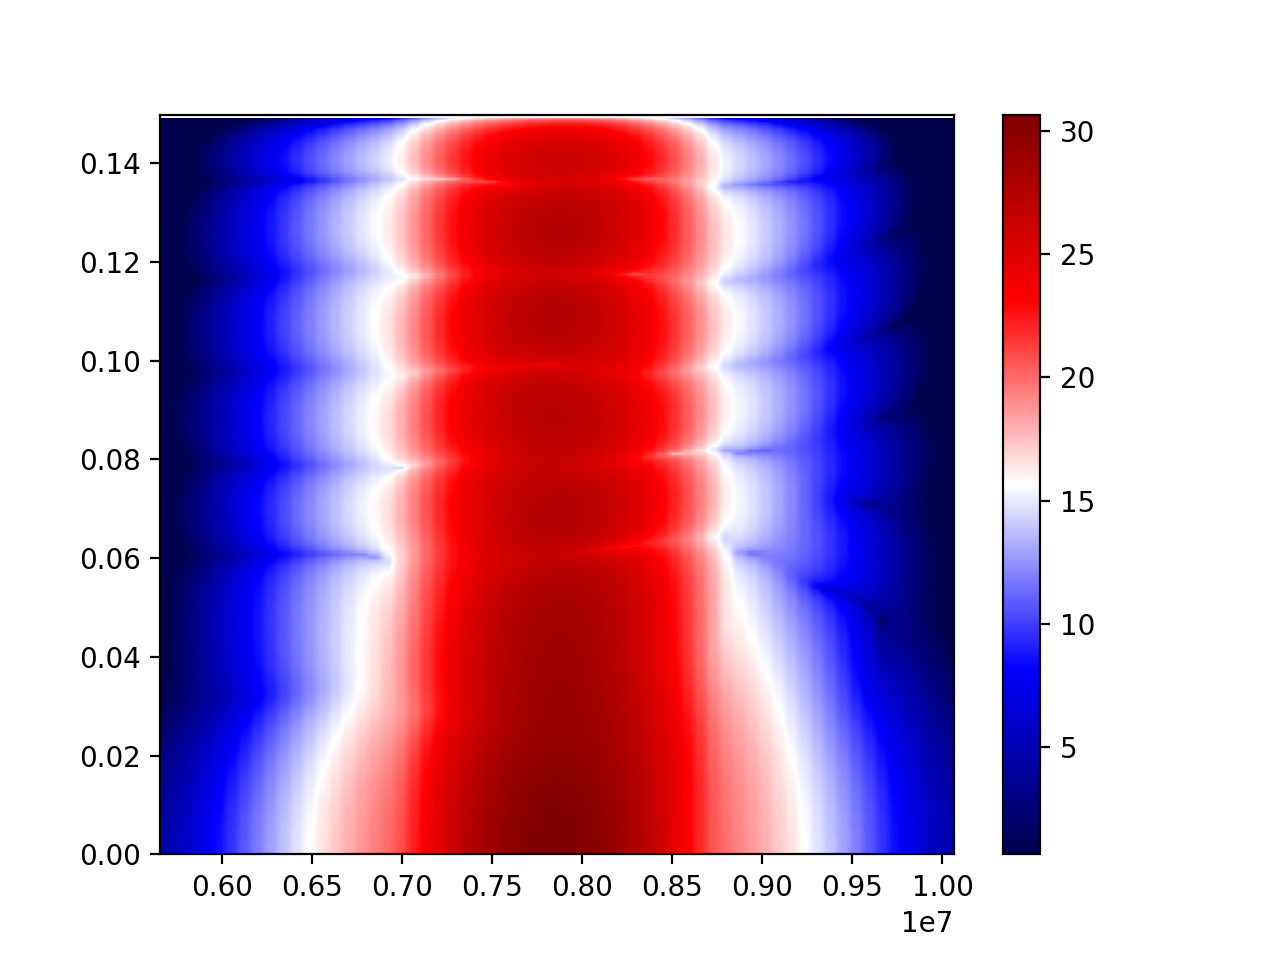

/tmp/ipykernel_31260/3821861066.py:10: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(val).T,


In [12]:
field_name = 'E_foc'

ext = np.array([Fields[field_name].k_freq.min(), Fields[field_name].k_freq.max(), 
                0, Fields[field_name].r.max()*1e3])

#val = unwrap(np.angle(Fields[field_name].Field_ft))
val = np.abs(Fields[field_name].Field_ft)

plt.figure()
plt.imshow(np.log(val).T, 
           origin='lower', aspect='auto', 
           extent=ext, 
           cmap=plt.cm.seismic,
           vmin=np.log(val.max())-30
          )
plt.colorbar()



#plt.xlim(-75e-15, 75e-15)
#plt.ylim(0, 0.04)

#plt.figure()
#plt.plot(Fields['J_plasma'].r, n_e)

#plt.figure()
#plt.plot(Fields['J_plasma'].r, T_e)